# 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기
## step1. 데이터셋 내려받기

- 이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다. 
- tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.(https://www.tensorflow.org/datasets/catalog/tf_flowers)
- tfds.load를 활용하여 데이터셋을 다운받으세요.   



In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# tensroflow_datasets 패키지가 없다면 설치하자.
tfds.__version__

'4.4.0'

In [191]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers', # 3.670 items
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)



print(raw_train)
print(raw_validation)
print(raw_test)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## step2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
- 이미지를 모두 같은 크기로 formatting한 후, train_batches, validation_batches, test_batches를 준비한다.

In [27]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = image/255 # 픽셀값의 scale 수정 # 기존 0~255 정수값을 0~1사이 실수값으로 변경
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("완료")

완료


In [28]:
train= raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)


<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


In [189]:
# check
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

AttributeError: 'ClassLabel' object has no attribute 'name'

<Figure size 720x360 with 0 Axes>

## Step 3. 모델 설계하기
- 모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 base_model을 활용할 것인가요?
- 원하는 방식으로 모델을 만들어 보세요!
- cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요
   - 출력부분이 달라질 것 같다. softmax

In [78]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# model sequential

base_model = tf.keras.Sequential([
    model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [67]:
for image_batch, label_batch in train_batches.take(1):
    pass


image_batch.shape, label_batch.shape 

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## Step 4. 모델 학습시키기
- 모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.
- 예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.
- 또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.
- 어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.
- 이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

In [144]:
learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("완료")

완료


In [145]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("완료")

완료


In [146]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("완료")

완료


In [147]:
# 초기 손실과 정확도 검사
validation_steps= 10
loss0, accuracy0 = base_model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 1s 68ms/step - loss: 0.5177 - accuracy: 0.8250
initial loss: 0.52
initial accuracy: 0.82


In [148]:
EPOCHS = 10
history = base_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 8s 77ms/step - loss: 0.5240 - accuracy: 0.8174 - val_loss: 0.5452 - val_accuracy: 0.8011
Epoch 2/10
92/92 [==============================] - 8s 78ms/step - loss: 0.4577 - accuracy: 0.8365 - val_loss: 0.6948 - val_accuracy: 0.7602
Epoch 3/10
92/92 [==============================] - 8s 78ms/step - loss: 0.4373 - accuracy: 0.8464 - val_loss: 0.6265 - val_accuracy: 0.7820
Epoch 4/10
92/92 [==============================] - 8s 79ms/step - loss: 0.4087 - accuracy: 0.8501 - val_loss: 0.6736 - val_accuracy: 0.7684
Epoch 5/10
92/92 [==============================] - 8s 80ms/step - loss: 0.3993 - accuracy: 0.8522 - val_loss: 0.7344 - val_accuracy: 0.7411
Epoch 6/10
92/92 [==============================] - 8s 80ms/step - loss: 0.3786 - accuracy: 0.8638 - val_loss: 0.5571 - val_accuracy: 0.7984
Epoch 7/10
92/92 [==============================] - 8s 81ms/step - loss: 0.3625 - accuracy: 0.8692 - val_loss: 0.5670 - val_accuracy: 0.7766
Epoch 8/10
92

## Step 5. 모델 성능 평가하기
- 모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.
- 모델이 학습된 과정을 그래프로도 그려보고, validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

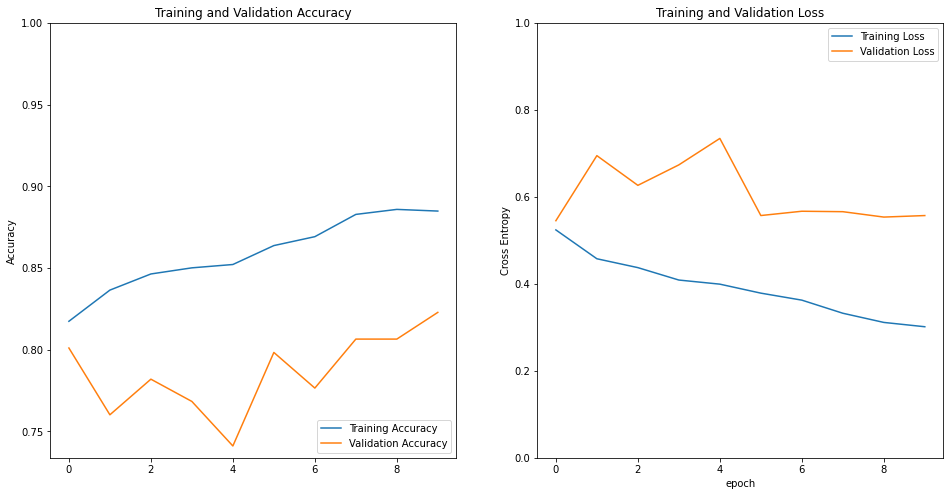

In [149]:
# 그래프로 학습과정을 보자

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [150]:
import numpy as np
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = base_model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 3, 2, 0, 0, 4, 1, 3, 0, 0, 3, 4, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

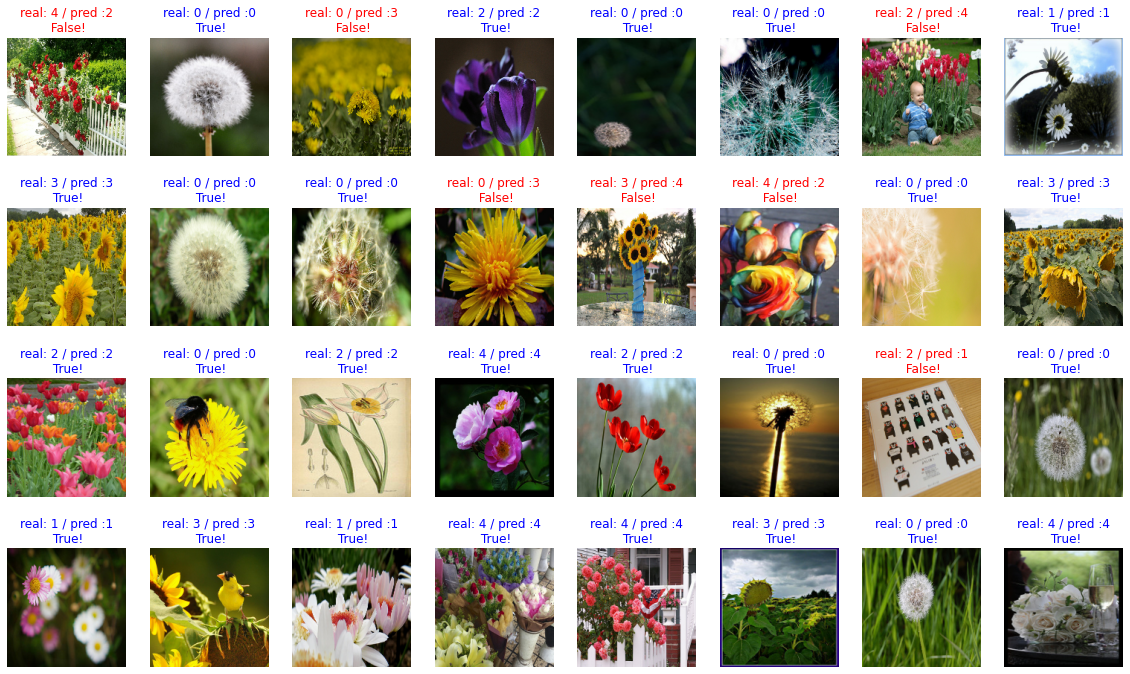

In [151]:
#확인

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [152]:
#정확도 측정
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

78.125


## Step 6. 모델 활용하기
- 모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.
- 원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!


In [153]:
import os
img_dir_path = os.getenv("HOME") + "/aiffel/flower/images"
os.path.exists(img_dir_path)

True

In [154]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [217]:
# image를 load & arrary로 변환(reshape) & predict & percentage

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    predictions = (base_model.predict(image)[0])
    prediction_idx = np.argmax((base_model.predict(image)[0]))
    
    flower_lists = metadata.features['label'].names
   
    print(f"This image seems {flower_lists[prediction_idx]} with {np.max(predictions) * 100}%.")


This image seems daisy with 100.0%.


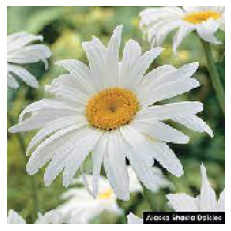

In [218]:
filename = 'daisy.jfif'
show_and_predict_image(img_dir_path, filename)

This image seems daisy with 100.0%.


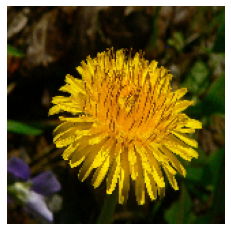

In [219]:
filename = 'dandelion.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems roses with 100.0%.


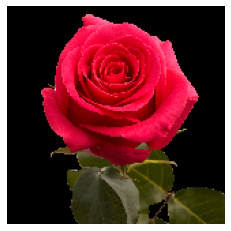

In [220]:
filename = 'roses.png'
show_and_predict_image(img_dir_path, filename)

This image seems sunflowers with 99.99990463256836%.


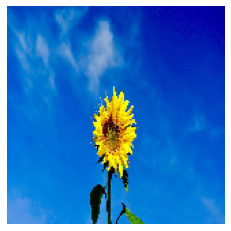

In [221]:
filename = 'sunflowers.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems sunflowers with 99.99990463256836%.


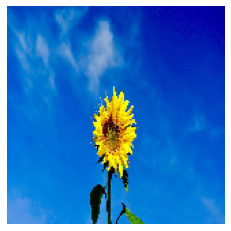

In [222]:
filename = 'sunflowers.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems roses with 100.0%.


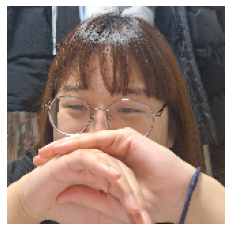

In [224]:
filename = 'angie.jpg'
show_and_predict_image(img_dir_path, filename)

This image seems dandelion with 100.0%.


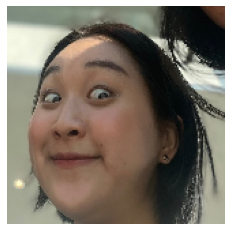

In [225]:
filename = 'dg.jpg'
show_and_predict_image(img_dir_path, filename)